### Exercises

E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

### Building dataset

In [4]:
words = open('../2_makemore_bigrams/names.txt','r').read().splitlines()

In [5]:
len(words)

32033

In [6]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [7]:
chars = sorted(list(set(''.join(words))))
stoi = {i:enum+1 for enum, i in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}

In [13]:
# build the dataset
block_size = 3

def build_dataset(words):
    X=[]
    Y=[]
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [15]:
import random
random.seed(42)
random.shuffle(words)

In [17]:
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

In [19]:
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Batchnorm

In [398]:
device = torch.device('mps')
Xtr = Xtr.to(device)
Ytr = Ytr.to(device)
Xdev = Xdev.to(device)
Ydev = Ydev.to(device)
Xte = Xte.to(device)
Yte = Yte.to(device)

In [404]:
n_emb = 100
n_hidden = 100
losses_train = []
losses_dev = []
g = torch.Generator(device=device).manual_seed(99)
C = torch.randn((27, n_emb), generator=g, device=device) * 0.01
W1 = torch.randn((n_emb*3, n_hidden), generator=g, device=device) * (5/3) / ((n_emb*3)**0.5)
b1 = torch.randn(n_hidden, generator=g, device=device) * 0.01
W2 = torch.randn((n_hidden,27), generator=g, device=device) / ((n_hidden)**0.5)
b2 = torch.randn(27, generator=g, device=device) * 0.01
bnorm_running_mean = torch.zeros((1,n_hidden) ,device=device)
bnorm_running_std = torch.ones((1,n_hidden) ,device=device)
bnorm_gain = torch.ones((1,n_hidden) ,device=device)
bnorm_bias = torch.zeros((1,n_hidden) ,device=device)
parameters = [C, W1,W2,b1,b2, bnorm_bias, bnorm_gain]
for p in parameters:
    p.requires_grad = True
print(f"Total parameters : {sum(p.nelement() for p in parameters)}")

for steps in range(1,200000+1):
    minibatch = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[minibatch]].view(-1, n_emb*3)
    l1preact = emb @ W1 + b1
    #BATCH NORM LAYER----------------
    bnorm_mean = l1preact.mean(dim=0,keepdim=True)
    bnorm_std = l1preact.std(dim=0,keepdim=True)
    bnorm_l1preact = bnorm_gain * (l1preact - bnorm_mean) / bnorm_std + bnorm_bias
    with torch.no_grad():
        bnorm_running_mean = bnorm_running_mean*0.99 + bnorm_mean*0.01
        bnorm_running_std = bnorm_running_std*0.99 + bnorm_std*0.01
    #---------------------------------
    l1 = torch.tanh(bnorm_l1preact)
    
    logits = l1 @ W2 + b2
    loss_train = F.cross_entropy(logits, Ytr[minibatch])
    for p in parameters:
        p.grad = None
    loss_train.backward()
    lr = 0.1 if steps < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    losses_train.append(loss_train.log10().item())
    if (steps%10000) == 0:
        print(f"Steps : {steps} / 200000  -> loss_train :  {round(loss_train.item(),3)}")
        
    # with torch.no_grad():
    #     emb = C[Xdev].view(-1, n_emb*3)
    #     l1 = torch.tanh(emb @ W1 + b1)
    #     logits = l1 @ W2 + b2
    #     loss_dev = F.cross_entropy(logits, Ydev)
    #     losses_dev.append(loss_dev.log10().item())

    # break
        
# print(f"loss_train | loss_dev : {round(loss_train.item(),3)} | {round(loss_dev.item(),3)}")
print(f"\nFinal loss_train :  {round(loss_train.item(),3)}")


Total parameters : 35727
Steps : 10000 / 200000  -> loss_train :  2.173
Steps : 20000 / 200000  -> loss_train :  2.409
Steps : 30000 / 200000  -> loss_train :  2.246
Steps : 40000 / 200000  -> loss_train :  2.045
Steps : 50000 / 200000  -> loss_train :  2.475
Steps : 60000 / 200000  -> loss_train :  1.983
Steps : 70000 / 200000  -> loss_train :  2.191
Steps : 80000 / 200000  -> loss_train :  2.226
Steps : 90000 / 200000  -> loss_train :  1.898
Steps : 100000 / 200000  -> loss_train :  2.339
Steps : 110000 / 200000  -> loss_train :  2.188
Steps : 120000 / 200000  -> loss_train :  1.843
Steps : 130000 / 200000  -> loss_train :  2.452
Steps : 140000 / 200000  -> loss_train :  1.958
Steps : 150000 / 200000  -> loss_train :  2.008
Steps : 160000 / 200000  -> loss_train :  1.859
Steps : 170000 / 200000  -> loss_train :  2.34
Steps : 180000 / 200000  -> loss_train :  2.255
Steps : 190000 / 200000  -> loss_train :  2.402
Steps : 200000 / 200000  -> loss_train :  1.997

Final loss_train :  1.99

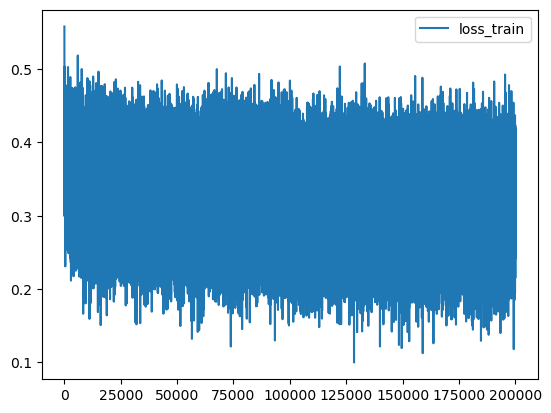

In [405]:
plt.plot(list(range(len(losses_train))), losses_train, label='loss_train')
# plt.plot(list(range(len(losses_dev))), losses_dev, label='loss_dev')
plt.legend()

In [440]:
def split_loss(split):
    X = {'train' : Xtr, 'dev': Xdev, 'test' : Xte}
    Y = {'train' : Ytr, 'dev': Ydev, 'test' : Yte}
    with torch.no_grad():
        emb = C[X[split]].view(-1, n_emb*3)
        l1preact = emb @ W1 + b1
        bnorm_l1preact = bnorm_gain * (l1preact - bnorm_running_mean) / bnorm_running_std + bnorm_bias
        l1 = torch.tanh(bnorm_l1preact)
        logits = l1 @ W2 + b2
        loss = F.cross_entropy(logits, Y[split])
        print(f"Loss {split} : {round(loss.item(),3)}")

In [442]:
split_loss('train')

Loss train : 2.057


In [446]:
split_loss('dev')

Loss dev : 2.103


In [448]:
split_loss('test')

Loss test : 2.101


In [94]:
torch.tensor([[0,1,2]]).shape

torch.Size([1, 3])

### Pytorch-ification

In [657]:
class TanH:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Linear:
    def __init__(self, fan_in, fan_out, device = torch.device('mps'), bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g, device=device)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1, device = torch.device('mps')):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim, device=device) 
        self.beta = torch.zeros(dim, device=device) 
        self.running_mean = torch.zeros(dim, device=device) 
        self.running_var = torch.ones(dim, device=device) 

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        self.out = self.gamma * (x - xmean) / torch.sqrt(xvar + self.eps) + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + xmean*self.momentum
                self.running_var = (1-self.momentum)*self.running_var + xvar*self.momentum 
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
                


In [659]:
g = torch.Generator(device=torch.device('mps')).manual_seed(32131231)
n_emb = 10
n_hidden = 100
vocab_size = 27
C = torch.randn((vocab_size, n_emb), generator=g, device=torch.device('mps'))

In [661]:
block_size = 3

layers = [
    Linear(n_emb*block_size, n_hidden, bias=False), BatchNorm1D(n_hidden), TanH(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), TanH(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), TanH(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), TanH(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), TanH(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1D(vocab_size)
]

In [663]:
with torch.no_grad():
    layers[-1].gamma *= 0.1

In [665]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]

In [667]:
sum(p.nelement() for p in parameters)

47024

In [669]:
for p in parameters:
    p.requires_grad = True

In [727]:
batch_size = 32
max_steps = 200000
lossi = []
ud = []
for step in range(1,max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g, device=torch.device('mps'))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(-1, n_emb*block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if step < (max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    lossi.append(loss.log10().item())
    if step%10000 == 0:
        print(f"Step : {step} / {max_steps} -> Loss  : {loss.item():.4f}")

    with torch.no_grad():
        ud.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])

In [737]:
ud[0]

[-3.60436749458313,
 -4.159110069274902,
 -0.31102633476257324,
 -0.2745992839336395,
 -4.468003749847412,
 -0.32522809505462646,
 -0.27406927943229675,
 -4.479326248168945,
 -0.23866014182567596,
 -0.30176588892936707,
 -4.536012172698975,
 -0.2748187482357025,
 -0.23691540956497192,
 -4.601803302764893,
 -0.2952340841293335,
 -0.23559574782848358,
 -4.392425060272217,
 -0.3684380352497101,
 -0.5285762548446655]